In [12]:
import pandas as pd

# Try loading with alternate encoding
df = pd.read_csv("/content/imdb_india.csv", encoding='ISO-8859-1')
df.head()


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [20]:
# CLEAN YEAR COLUMN
if 'Year' in df.columns:
    df['Year'] = df['Year'].astype(str).str.extract(r'(\d{4})')
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# CLEAN DURATION COLUMN
if 'Duration' in df.columns:
    df['Duration'] = df['Duration'].astype(str).str.replace('min', '', regex=False).str.strip()
    df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')

# CLEAN VOTES COLUMN ✅ (this caused your previous error)
if 'Votes' in df.columns:
    df['Votes'] = df['Votes'].astype(str).str.replace(',', '')
    df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

# COMBINE ACTORS
if all(x in df.columns for x in ['Actor 1', 'Actor 2', 'Actor 3']):
    df['Actors'] = df[['Actor 1', 'Actor 2', 'Actor 3']].apply(
        lambda row: ', '.join([str(actor) for actor in row if pd.notnull(actor)]),
        axis=1
    )


In [22]:
# Add a new column: count of actors per movie
df['Actor_Count'] = df['Actors'].apply(lambda x: len(str(x).split(',')))

# Create a new column: average rating of each director
df['Director_Avg_Rating'] = df.groupby('Director')['Rating'].transform('mean')

# Drop rows that still have missing important values
df = df.dropna(subset=['Rating', 'Runtime (Minutes)', 'Votes', 'Director_Avg_Rating'])

# Define input features and target
features = ['Genre', 'Runtime (Minutes)', 'Votes', 'Year', 'Actor_Count', 'Director_Avg_Rating']
target = 'Rating'

X = df[features]
y = df[target]


In [23]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Define column types
categorical_cols = ['Genre']
numeric_cols = ['Runtime (Minutes)', 'Votes', 'Year', 'Actor_Count', 'Director_Avg_Rating']

# Create preprocessing pipeline
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])


In [24]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [25]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Create pipeline: preprocessing + model
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Genre']),
                                                 ('num', StandardScaler(),
                                                  ['Runtime (Minutes)', 'Votes',
                                                   'Year', 'Actor_Count',
                                                   'Director_Avg_Rating'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # manually take square root
r2 = r2_score(y_test, y_pred)

print("✅ Root Mean Squared Error (RMSE):", rmse)
print("✅ R² Score:", r2)


✅ Root Mean Squared Error (RMSE): 0.7352269310702242
✅ R² Score: 0.7119457628272094


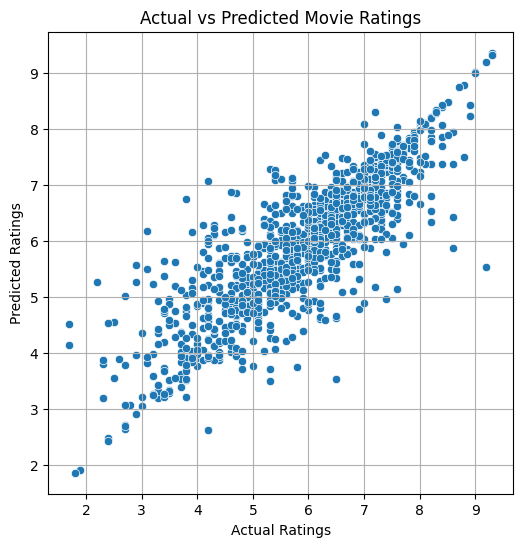

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Movie Ratings")
plt.grid(True)
plt.show()
